In [1]:
!pip install ta
!pip install xgboost
!pip install shap
import numpy as np
import pandas as pd
import ta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import shap

**Cleaning and Preping the data**

In [2]:
#Load the CSV File
path= "pathTCS_DATA.csv"

In [3]:
df = pd.read_csv(path)

In [4]:
df.head()
df.info()
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5162 entries, 0 to 5161
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    5162 non-null   object
 1   Symbol  5162 non-null   object
 2   Open    5162 non-null   object
 3   High    5162 non-null   object
 4   Low     5162 non-null   object
 5   Close   5162 non-null   object
 6   Volume  5162 non-null   object
dtypes: object(7)
memory usage: 282.4+ KB


Date      object
Symbol    object
Open      object
High      object
Low       object
Close     object
Volume    object
dtype: object

In [5]:
cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

In [6]:
df.dtypes

Date       object
Symbol     object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [7]:
#to format date to datetime
df["Date"] = pd.to_datetime(df["Date"], format='%d-%m-%Y')

In [8]:
#Sort by Date
df = df.sort_values('Date').reset_index(drop=True)

In [9]:
#handling missing values
df.isnull().sum()

#dropping missing values
df = df.dropna()

In [10]:
df.to_csv("F:/ML/TCS/cleaned_df.csv", index= False)

**Feature Engineering**:  
to capture temporal patterns, trends, and momentum.

In [11]:
#Lag features
df['lag_1'] = df['Close'].shift(1)
df['lag_2'] = df['Close'].shift(2)
df['lag_3'] = df['Close'].shift(3)

In [12]:
#Rolling Statistics
df['rolling_mean_3'] = df['Close'].rolling(window=3).mean()
df['rolling_std_5'] = df['Close'].rolling(window=5).std()

In [13]:
#Daily Returns (Percentage Change)
df['daily_return'] = df['Close'].pct_change()

In [14]:
#Technical Indicators 
# Add RSI (momentum indicator)
df['rsi'] = ta.momentum.RSIIndicator(df['Close']).rsi()

# Add MACD (trend-following momentum indicator)
df['macd'] = ta.trend.MACD(df['Close']).macd()

In [15]:
#Creating the Target Variable
df['target'] = df['Close'].shift(-1)

In [16]:
#Drop NaNs (due to shifting and rolling)
df = df.dropna()

**Model Building**:  
We use multiple models to see and compare how well each model performs. Later, select the best one for SHAP explainability.

In [17]:
# Define input features
feature_cols = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_5', 'daily_return', 'rsi', 'macd']

X = df[feature_cols]
y = df['target']

In [18]:
#Train-Test Split (without shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
#Define and Train Each Model
# XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Lasso Regression
lasso = Lasso(alpha=1.0, max_iter=50000) 
lasso.fit(X_train, y_train)


Lasso(max_iter=50000)

In [20]:
#Predict and Evaluate with a common evaluation function
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"{name}:\n RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%\n")

In [21]:
#The percentage error
evaluate_model("XGBoost", xgb)
evaluate_model("Random Forest", rf)
evaluate_model("Lasso", lasso)

XGBoost:
 RMSE: 987.34, MAE: 773.84, MAPE: 20.29%

Random Forest:
 RMSE: 948.87, MAE: 717.93, MAPE: 18.55%

Lasso:
 RMSE: 47.62, MAE: 34.23, MAPE: 0.95%



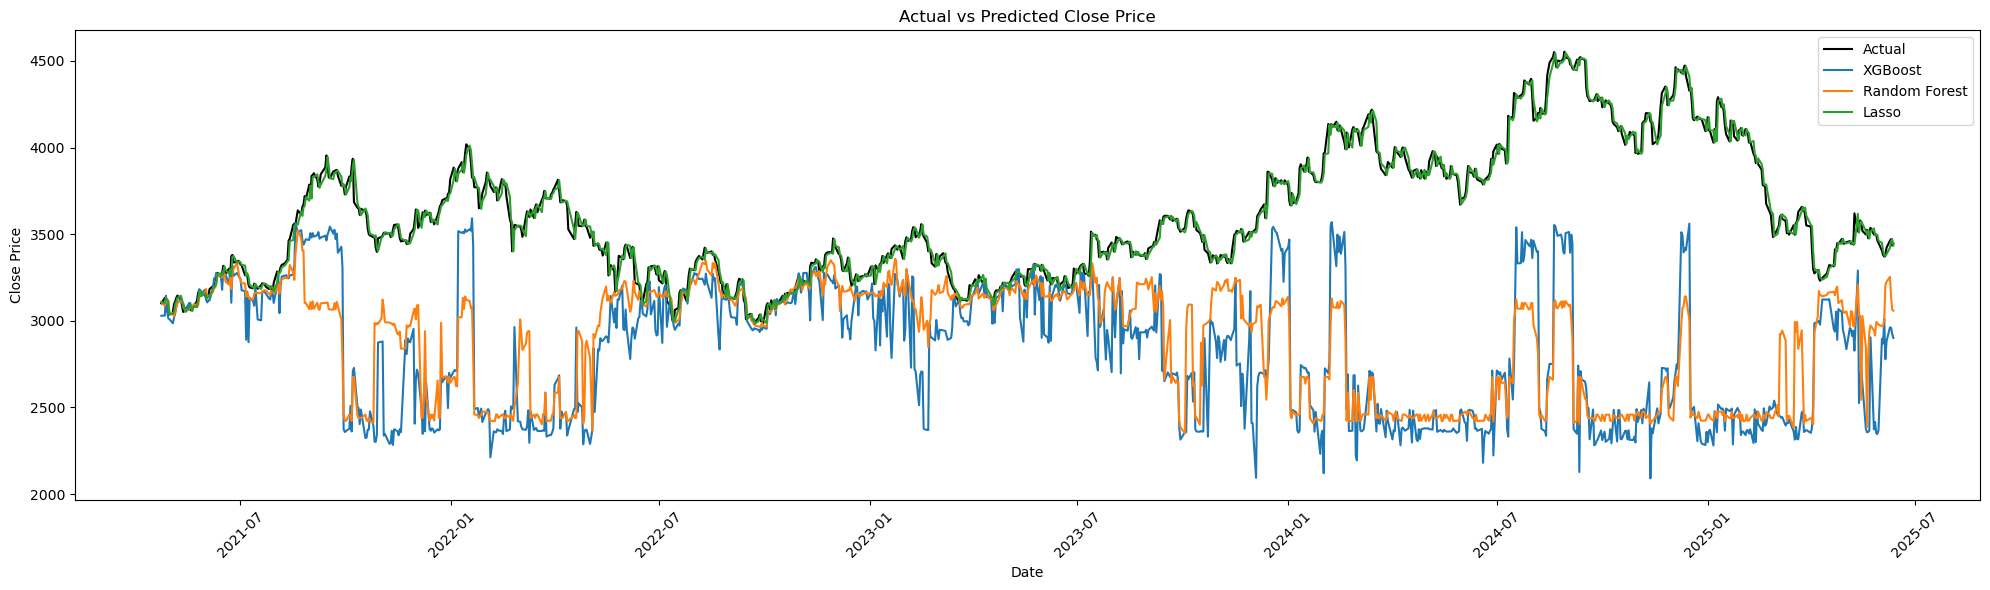

In [22]:
# Extract dates that correspond to X_test indices
dates = df['Date'].loc[X_test.index] 

# Visualize Predictions for Each Model to compare
plt.figure(figsize=(20,6))
plt.plot(dates, y_test.values, label='Actual', color='black')
plt.plot(dates, xgb.predict(X_test), label='XGBoost')
plt.plot(dates, rf.predict(X_test), label='Random Forest')
plt.plot(dates, lasso.predict(X_test), label='Lasso')
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Interpretation:
- Both models XGBoost & Random Forest are giving similar results, with Random Forest slightly better across all metrics.
- RMSE and MAE in the 700–900 range are expected if the stock price itself is around ₹1,000–₹3,000.
- MAPE ~18–20% suggests the model can be off by ±20% on average — not ideal but plausible for volatile stock price prediction.
- RMSE and MAE are incredibly low (almost too perfect) for Lasso Regression.
- MAPE is just 0.95%, which is extremely rare in real-world stock predictions.  
Hence, we choose Random Forest for SHAP interpretation — it's slightly better and works well with tree-based SHAP.

##  Model Explainability using SHAP

To ensure transparency and interpretability of the model, we used **SHAP (SHapley Additive exPlanations)** to analyze feature contributions for the next-day stock price predictions.

In [23]:
#Initializing SHAP Explainer for Random Forest Regression
explainer = shap.Explainer(rf, X_test)

# Calculate SHAP values
shap_values = explainer(X_test)

 94%|=================== | 964/1028 [00:11<00:00]       

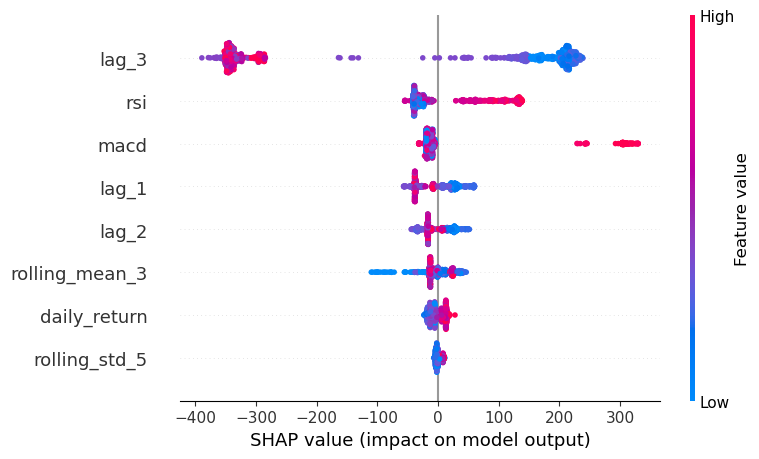

In [24]:
#SHAP summary plot
shap.summary_plot(shap_values, X_test)

###  SHAP Summary Plot
The SHAP summary plot visualizes the impact of each feature on the model's output across all predictions.

- **Top impactful features**:
  - `lag_3` (TCS close price from 3 days ago)
  - `rsi` (Relative Strength Index)
  - `macd` (Moving Average Convergence Divergence)
  - `lag_1`, `lag_2`
- **Color meaning**:
  - Red = High feature value
  - Blue = Low feature value
- **Interpretation**: High values of `lag_3` push the prediction upward, indicating strong temporal dependency.

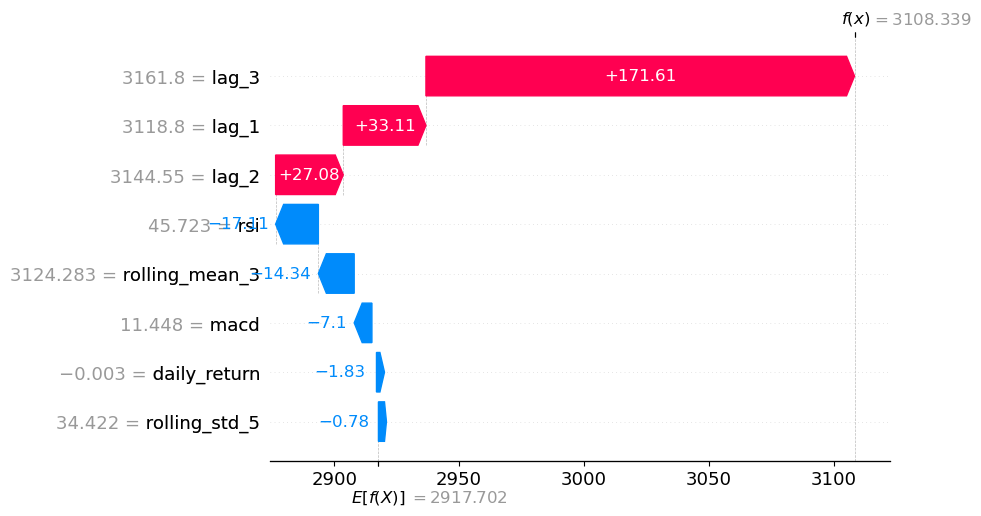

In [25]:
#SHAP Waterfall Plot (Individual Prediction) to explain deeply
shap.plots.waterfall(shap_values[0])  # 0 can be replaced with any index

###  SHAP Waterfall Plot (Single Prediction)
The waterfall plot shows how each feature contributed to one specific prediction.

- The base value (average model output) starts at **~2917.70**.
- The final predicted close price is **3108.34**.
- Major positive contributors:
  - `lag_3` (+171.61)
  - `lag_1`, `lag_2`
- Minor negative contributors:
  - `rsi`, `rolling_mean_3`, `macd`, `daily_return`

This plot explains "why" the model predicted a certain value for a single test instance.

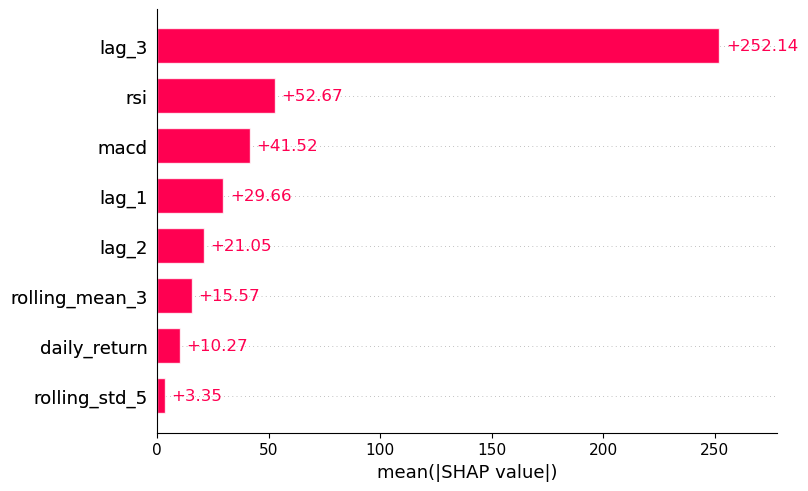

In [26]:
# SHAP Bar Plot for a quick glance at average feature importance
shap.plots.bar(shap_values)

###  SHAP Bar Plot (Mean Absolute Impact)
This plot shows the **average importance** of each feature across all predictions.

| Feature         | Mean SHAP Value |
|----------------|------------------|
| `lag_3`        | 252.14           |
| `rsi`          | 52.67            |
| `macd`         | 41.52            |
| `lag_1`        | 29.66            |
| `lag_2`        | 21.05            |
| `rolling_mean_3` | 15.57          |
| `daily_return` | 10.27            |
| `rolling_std_5`| 3.35             |

###  Conclusion
- The model shows **high dependency on lag features**, especially `lag_3`.
- Technical indicators (`rsi`, `macd`) also influence predictions but to a lesser extent.
- SHAP enhances the **explainability** of the model, aligning with the goal of transparency in financial forecasting.